# Embedding 1D CNN (feat. Soft Ordering 1D CNN) 모델 코드

## 개발 환경 및 라이브러리 버전
- 개발환경: Colab Pro 
- 런타임 유형: TPU, 고용량 RAM
- os: Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
- tensorflow: 2.5.0
- tensorflow.keras: 2.5.0
- tensorflow_addons: 0.13.0
- pandas: 1.1.5
- numpy: 1.19.5
- sklearn: 0.22.2.post1
- kiwipiepy: 0.9.3
- tqdm : 4.62.0

## 구글 드라이브 연결

In [2]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필요한 패키지 설치하기

In [3]:
!pip install kiwipiepy==0.9.3 # 한국어 형태소 분석 패키지! 리더보드 재현시 사용한 버전 = 0.9.3
!pip install tensorflow-addons 
colab.output.clear()

## 데이터 경로 및 전역 변수 설정
- IS_LOAD_WEIGHTS 변수
    - True: 리더보드 점수 재현을 위해 모델 가중치 불러옵니다.
    - False: 주의!! 모델이 다시 학습합니다. 
- DATA_PATH 변수
    - dacon 에서 제공한 train.csv, test.csv , sample_submission.csv 경로
- CLEANED_PATH
    - train.csv, test.csv 파일 형태소 분석 완료 파일 저장 경로
- SUBMIT_INPUT_PATH 변수
    - 최종 앙상블을 위해 추론확률값(npy 형태) 파일을 저장할 경로
- SUBMIT_OUTPUT_PATH 변수
    - 단독모델 제출파일.csv 저장 경로
- MODELS_PATH 변수
    - 리더보드 점수를 재현을 위한 모델 가중치 저장 또는 저장된 경로
- save_weights_name 변수
    - 새로 모델 학습시 가중치 저장할 파일명
    - IS_LOAD_WEIGHTS = True 일 경우 해당사항 없음

In [4]:
IS_LOAD_WEIGHTS = True

DATA_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/data/" # 학습및 테스트 데이터 폴더
CLEANED_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/cleaned/" #학습및 테스트 데이터 형태소 분석 완료 파일 저장 폴더
SUBMIT_INPUT_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/submit/input/" # 앙상블 하기위해 예측확률 npy 파일 저장 폴더
SUBMIT_OUTPUT_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/submit/output/" #  단독 모델 추론 csv 파일 저장 경로
MODELS_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/embedding_1d_cnn/" # 모델 가중치 저장 또는 불러오는 폴더

SEED = 42 # 시드값 전역변수
save_weights_name = "embedding_1d_cnn_weights_new_" # 새로 모델 학습후 가중치 저장할 파일명

In [5]:
if IS_LOAD_WEIGHTS:
    save_weights_name = "embedding_1d_cnn_weights_" # 리더보드 재현을 위한 모델 가중치 파일명

save_weights_name

'embedding_1d_cnn_weights_'

## 라이브러리

In [6]:
import os
import sys
import platform
import random
import re
import math
import gc
 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer  , TfidfVectorizer
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow_addons as tfa

import kiwipiepy
from kiwipiepy import Kiwi

import warnings
warnings.filterwarnings(action='ignore')
 
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- tensorflow: {tf.__version__}")
print(f"- tensorflow.keras: {tf.keras.__version__}")
print(f"- tensorflow_addons: {tfa.__version__}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- kiwipiepy: {kiwipiepy.__version__}")

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


- os: Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
- tensorflow: 2.6.0
- tensorflow.keras: 2.6.0
- tensorflow_addons: 0.13.0
- pandas: 1.1.5
- numpy: 1.19.5
- sklearn: 0.22.2.post1
- kiwipiepy: 0.9.3


- TPU 주소 불러오기

In [7]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.111.215.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.111.215.250:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## 함수 및 클래스 정의

In [8]:
class FeatureGenerator:
    '''데이터 프레임을 받아 cols_not_sparse 리스트의 지정된 피쳐와 tdm or tfidf 피쳐를 생성하는 클래스

    Args:
        vec_num (int): tdm or tfidf max_features
        is_tdm (bool): tdm 생성여부
        is_tfidf (bool): tfidf 생성여부
        cols_vec (list): tdm or tfidf 생성 컬럼  리스트
        cols_not_sparse (list): 데이터 프레임안에 피쳐로 선택하고자 하는 컬럼명 리스트(예를들어 원핫 인코딩된 컬럼 등...)
 
    Attributes:
        ...
        count_vec (dict): CountVectorizer 객체를 컬럼명 별로 저장
        tfidf_vec (dict): TfidfVectorizer 객체를 컬럼명 별로 저장
        is_fitted (bool): fit 여부
        num_features(int) : 생성 되는 설명변수 개수 

    Examples:
         >>> fg = FeatureGenerator(vec_num = 500 ,
                          cols_vec = ["요약문_한글키워드_pre"] , 
                          is_tdm = False, is_tfidf = True ,cols_not_sparse=cols_not_sparse)
    
         >>> x_train = fg.fit_transform(train) 
         >>> x_test = fg.transform(test)
    '''
    def __init__(self, vec_num = 500 , is_tdm = True, is_tfidf = True  , 
                 cols_vec = ["요약문_한글키워드","요약문_영문키워드"] ,
                 cols_not_sparse = [] ):
        
        self.is_tdm = is_tdm
        self.is_tfidf = is_tfidf
        # self.scaler = MinMaxScaler()
        self.vec_num = vec_num
        self.cols_vec = cols_vec
        self.cols_not_sparse = cols_not_sparse
        self.count_vec = {}
        self.tfidf_vec = {}

        self.is_fitted = False
        self.num_features = len(cols_not_sparse)
        
    # private    
    def __make_features(self,x):
        x_tmp = x[self.cols_not_sparse]
        
        if self.is_tdm:
            for col in self.cols_vec:
                tmp = self.count_vec[col].transform(x[col])
                x_tmp = pd.concat([
                    x_tmp,
                    pd.DataFrame(tmp.A).add_prefix(f"tdm_{col}_") 
                ],axis=1)

        if self.is_tfidf:
            for col in self.cols_vec:
                tmp = self.tfidf_vec[col].transform(x[col])
                x_tmp = pd.concat([
                    x_tmp,
                    pd.DataFrame(tmp.A).add_prefix(f"tfidf_{col}_") 
                ],axis=1)
        
        return x_tmp

    def fit(self,x ):
        if self.is_tdm:
            for col in self.cols_vec:
                count_vec = CountVectorizer(max_features=self.vec_num)
                count_vec.fit(x[col])
                self.count_vec[col] = count_vec
                self.num_features += len(count_vec.get_feature_names())
        
        if self.is_tfidf:
            for col in self.cols_vec:
                tfidf_vec = TfidfVectorizer(max_features=self.vec_num)
                tfidf_vec.fit(x[col])
                self.tfidf_vec[col] = tfidf_vec
                self.num_features += len(tfidf_vec.get_feature_names())

        self.is_fitted =  True
        
    def fit_transform(self,x):
        self.fit(x)
        x = self.__make_features(x)
        return x

    def transform(self,x):
        if not self.is_fitted:
            print("This FeatureGenerator instance is not fitted yet")
            return
        x = self.__make_features(x)
        return x
print(FeatureGenerator.__doc__)

데이터 프레임을 받아 cols_not_sparse 리스트의 지정된 피쳐와 tdm or tfidf 피쳐를 생성하는 클래스

    Args:
        vec_num (int): tdm or tfidf max_features
        is_tdm (bool): tdm 생성여부
        is_tfidf (bool): tfidf 생성여부
        cols_vec (list): tdm or tfidf 생성 컬럼  리스트
        cols_not_sparse (list): 데이터 프레임안에 피쳐로 선택하고자 하는 컬럼명 리스트(예를들어 원핫 인코딩된 컬럼 등...)
 
    Attributes:
        ...
        count_vec (dict): CountVectorizer 객체를 컬럼명 별로 저장
        tfidf_vec (dict): TfidfVectorizer 객체를 컬럼명 별로 저장
        is_fitted (bool): fit 여부
        num_features(int) : 생성 되는 설명변수 개수 

    Examples:
         >>> fg = FeatureGenerator(vec_num = 500 ,
                          cols_vec = ["요약문_한글키워드_pre"] , 
                          is_tdm = False, is_tfidf = True ,cols_not_sparse=cols_not_sparse)
    
         >>> x_train = fg.fit_transform(train) 
         >>> x_test = fg.transform(test)
    


In [9]:
class TextTokenizer:
    '''text 를 Tokenizer  & pad_sequences 처리하는 클래스

    Args:
        num_words (None or int):  Tokenizer 의 num_words
        maxlen (int): pad_sequences 의 maxlen
        padding (str): pad_sequences 의 padding
        filters (str): Tokenizer 의 filters
 
    Attributes:
        ...
        is_fitted (bool): fit 여부

    Examples:
        >>> tt = TextTokenizer(maxlen = 100 ,padding = "post" ,filters='!"#$%&()*+,-.:;<=>?@[\\]^_`{|}~\t\n')
        >>> x_train = tt.fit_transform(train["컬럼명"])
        >>> x_test = tt.transform(test["컬럼명"])
    '''
    def __init__(self,num_words=None , maxlen = 100,padding = "pre" ,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='<unk>' , filters = filters)
        self.maxlen = maxlen
        self.padding = padding
        self.is_fitted = False
    def fit(self,x, is_fit_transform = False):
        self.tokenizer.fit_on_texts(x)
        self.is_fitted = True

    def fit_transform(self,x):
        self.fit(x)
        x = self.tokenizer.texts_to_sequences(x)
        x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding=self.padding)
        return x

    def transform(self,x):
        if not self.is_fitted:
            print("This TextTokenizer instance is not fitted yet")
            return
        x = self.tokenizer.texts_to_sequences(x)
        x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding=self.padding)
        return x

print(TextTokenizer.__doc__)

text 를 Tokenizer  & pad_sequences 처리하는 클래스

    Args:
        num_words (None or int):  Tokenizer 의 num_words
        maxlen (int): pad_sequences 의 maxlen
        padding (str): pad_sequences 의 padding
        filters (str): Tokenizer 의 filters
 
    Attributes:
        ...
        is_fitted (bool): fit 여부

    Examples:
        >>> tt = TextTokenizer(maxlen = 100 ,padding = "post" ,filters='!"#$%&()*+,-.:;<=>?@[\]^_`{|}~	
')
        >>> x_train = tt.fit_transform(train["컬럼명"])
        >>> x_test = tt.transform(test["컬럼명"])
    


In [10]:
def reset_seeds(seed = 42):
    '''시드 고정 함수

    Args:
        seed (int): 시드값
    '''
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    print(f"RANDOM SEEDS RESET {seed}")  
print(reset_seeds.__doc__)

시드 고정 함수

    Args:
        seed (int): 시드값
    


In [11]:
def macro_f1(y_true, y_pred):
    '''Macro-F1 함수

    Args:
        y_true (ndarray): 정답값
        y_pred (ndarray): 예측값
    
    Returns:
        float: Macro-F1 Score
    '''
    y_pred = tf.argmax(y_pred,axis=1)
    return f1_score(y_true, y_pred, average='macro')

print(macro_f1.__doc__)

Macro-F1 함수

    Args:
        y_true (ndarray): 정답값
        y_pred (ndarray): 예측값
    
    Returns:
        float: Macro-F1 Score
    


In [12]:
def get_onehot(y):
    '''넘파이 배열 원핫 인코딩 함수
    Args:
        y (ndarray): 원핫인코딩 하고자하는 배열

    Returns:
        ndarray: 원핫 인코딩된 넘파일 배열
    '''
    num = np.unique(y, axis=0)
    num = num.shape[0]
    return np.eye(num)[y]

print(get_onehot.__doc__)

넘파이 배열 원핫 인코딩 함수
    Args:
        y (ndarray): 원핫인코딩 하고자하는 배열

    Returns:
        ndarray: 원핫 인코딩된 넘파일 배열
    


In [13]:
def soft_ordering_1d_cnn(x,d_size = 4096, ch_size = 512, k_size = 1,padding='valid', dense_shape1 = 16 ,conv_avg_size = 1 , conv_size = 3):
    '''soft-ordering-1d-cnn 구조를 케라스로 구현한 함수

    Args:
        x (tensor): 텐서
        d_size (int): 첫번째 dense 층의 노드 개수
        ch_size (int): 1D CNN 필터 개수
        k_size (int): 1D CNN 커널크기 
        padding (str): 1D CNN  패딩방식 
        dense_shape1 (int): 첫번째 dense 층에서 나온 노드를 1D CNN 에 넣기 위한 Step 사이즈
        conv_avg_size (int): Conv1D + AveragePooling1D 의 횟수
        conv_size (int): Conv1D의 횟수

    Returns:
        tensor: (batch, new_steps, filters)
    '''
    x = tf.keras.layers.Dense(d_size, activation="relu")(x)
    # x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.reshape(x,[ -1,dense_shape1,int(d_size / dense_shape1) ])
    for _ in range(conv_avg_size):
        x = tf.keras.layers.Conv1D(ch_size, k_size, activation="relu", padding=padding)(x)
        x = tf.keras.layers.AveragePooling1D(2)(x)

    for _ in range(conv_size):
        x = tf.keras.layers.Conv1D(ch_size, k_size, activation="relu", padding=padding)(x)
    
    x = tf.keras.layers.MaxPool1D(2)(x)
    
    return x
print(soft_ordering_1d_cnn.__doc__)

soft-ordering-1d-cnn 구조를 케라스로 구현한 함수

    Args:
        x (tensor): 텐서
        d_size (int): 첫번째 dense 층의 노드 개수
        ch_size (int): 1D CNN 필터 개수
        k_size (int): 1D CNN 커널크기 
        padding (str): 1D CNN  패딩방식 
        dense_shape1 (int): 첫번째 dense 층에서 나온 노드를 1D CNN 에 넣기 위한 Step 사이즈
        conv_avg_size (int): Conv1D + AveragePooling1D 의 횟수
        conv_size (int): Conv1D의 횟수

    Returns:
        tensor: (batch, new_steps, filters)
    


In [14]:
def build_model(seq_shape = [(10000,100),(10000,100),(10000,100)] ,embed_dim=512 , tab_shape = 10000,
                activation='relu' ,
                moa_dense_shape1 = 16 ,moa_conv_avg_size = 1 , moa_conv_size = 3, moa_padding = 'valid',
                label_smoothing=0. ,
                 optimizer="adam"):
    
    '''최종 모델 함수

    Args:
        seq_shape (list): Embedding 레이어의  input_dim 과 input_length 
        embed_dim (int): 
        tab_shape (int): 설명변수 개수
        activation (str): Conv1D 레이어 활성화함수
        loss (str or object): loss func
        moa_dense_shape1 (int): soft_ordering_1d_cnn 함수의 dense_shape1
        moa_conv_avg_size (int): soft_ordering_1d_cnn 함수의 conv_avg_size
        moa_conv_size (int): soft_ordering_1d_cnn 함수의 conv_size
        moa_padding (str): soft_ordering_1d_cnn 함수의 padding
        optimizer (str or object): optimizer
        label_smoothing (float): CategoricalCrossentropy label_smoothing

    Returns:
        object: 컴파일된 케라스 모델
    '''

    inputs_list = []
    concat_list = []

    for num_words , maxlen in seq_shape:

        inputs_seq = tf.keras.Input(shape=(maxlen, ))
        inputs_list.append(inputs_seq)
        x = inputs_seq
        x = tf.keras.layers.Embedding(num_words,embed_dim,input_length=maxlen)(x)
        
        # x = tf.keras.layers.Conv1D(int(embed_dim / 4), 3, activation=activation,padding="same")(x)
        # x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Conv1D(int(embed_dim / 2), 2, activation=activation,padding="valid")(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Conv1D(embed_dim, 1, activation=activation,padding="valid")(x)
        
       
        
        # x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.GlobalMaxPooling1D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        concat_list.append(x)
   
        

    inputs_tab = tf.keras.Input(shape=(tab_shape, ))
    inputs_list.append(inputs_tab)
    x = inputs_tab
    x = soft_ordering_1d_cnn(x,d_size = 2048, ch_size = embed_dim, k_size = 1,padding=moa_padding, dense_shape1 = moa_dense_shape1 ,conv_avg_size = moa_conv_avg_size , conv_size = moa_conv_size)
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    concat_list.append(x)


    x = tf.keras.layers.Concatenate()(concat_list)


    outputs = tf.keras.layers.Dense(46,activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inputs_list, outputs=outputs)

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
    f1 = tfa.metrics.F1Score(num_classes=46,average='macro')
    metrics = ['accuracy',f1]
    model.compile(loss=loss, optimizer=optimizer,metrics=metrics)
    return model
print(build_model.__doc__)

최종 모델 함수

    Args:
        seq_shape (list): Embedding 레이어의  input_dim 과 input_length 
        embed_dim (int): 
        tab_shape (int): 설명변수 개수
        activation (str): Conv1D 레이어 활성화함수
        loss (str or object): loss func
        moa_dense_shape1 (int): soft_ordering_1d_cnn 함수의 dense_shape1
        moa_conv_avg_size (int): soft_ordering_1d_cnn 함수의 conv_avg_size
        moa_conv_size (int): soft_ordering_1d_cnn 함수의 conv_size
        moa_padding (str): soft_ordering_1d_cnn 함수의 padding
        optimizer (str or object): optimizer
        label_smoothing (float): CategoricalCrossentropy label_smoothing

    Returns:
        object: 컴파일된 케라스 모델
    


In [15]:
reset_seeds(SEED)
tqdm.pandas()

# 키위 패키지 객체 생성 및 키위 모델준비
kiwi = Kiwi()
kiwi.prepare()

RANDOM SEEDS RESET 42


0

## 원본 학습 데이터 불러오기

In [16]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

## 시간 절약을 위해 미리 형태소 분석 처리한 train_pre.csv 와 test_pre.csv 파일을 불러온다
- CLEANED_PATH 경로에 형태소 분석 완료한 train_pre.csv와 test_pre.csv 파일이 없을 경우 형태소 분석 시작한다. 
- 대략 한시간 정도 소요
- 형태소 분석 처리한 컬럼은 다음과 같다.
    - '사업명' , '내역사업명', '과제명', '요약문_연구목표', '요약문_연구내용', '요약문_기대효과' , '요약문_한글키워드'


In [17]:
is_prefiles = True # train_pre.csv , test_pre.csv 파일 존재 여부 체크 변수
try:
    train = pd.read_csv(f'{CLEANED_PATH}train_pre.csv')
    test= pd.read_csv(f'{CLEANED_PATH}test_pre.csv')
except FileNotFoundError as e:
    is_prefiles = False
    print(e)

is_prefiles

True

In [18]:
# 형태소 분석을 위한 함수 정의
def extract_nvs(txt):
    tokens = [
          f"{token}/{pos}" 
          for token , pos ,_ ,_ in txt[0][0] 
            if pos.startswith('N') or pos.startswith('V') or pos == "SL"
    ]
    return " ".join(tokens)

- 아래 코드 총 소요시간
    
    - 100%|██████████| 7/7 [1:02:26<00:00, 535.27s/it] 
    - 총 60분 정도 소요(Colab Pro 런타임환경 GPU 기준)
    - 기존 소요시간 185분정도 였으나 내장함수(map,list)를 이용하여 소요시간 줄임


In [19]:
if not is_prefiles: # train_pre.csv , test_pre.csv 파일 없을 경우 형태소 분석 진행
    train = train.fillna("nan")
    test = test.fillna("nan")

    cols = ['사업명' , '내역사업명', '과제명', '요약문_연구목표', '요약문_연구내용', '요약문_기대효과' , '요약문_한글키워드']
    reg_txt = r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]" # 한글과 영문자가 아닐경우 공백으로 변경하기 위한 정규식
    for col in tqdm(cols): # 컬럼별로 처리
        result = kiwi.analyze( train[col].astype(str).str.replace(reg_txt," ") )
        result = map(extract_nvs , result)
        train[f"{col}_pre"] = list(result)

        result = kiwi.analyze( test[col].astype(str).str.replace(reg_txt," ") )
        result = map(extract_nvs , result)
        test[f"{col}_pre"] = list(result)

    #저장
    train.to_csv(f'{CLEANED_PATH}train_pre.csv', index=False)
    test.to_csv(f'{CLEANED_PATH}test_pre.csv', index=False)

    #다시 불러오기
    train = pd.read_csv(f'{CLEANED_PATH}train_pre.csv')
    test = pd.read_csv(f'{CLEANED_PATH}test_pre.csv')

## 텍스트컬럼에 대한 간단한 전처리 및 피쳐 추가

- 형태소 분석된 컬럼에서 품사 태그 제거하기

In [20]:
cols = ['사업명_pre' , '내역사업명_pre', '과제명_pre', '요약문_연구목표_pre', 
        '요약문_연구내용_pre', '요약문_기대효과_pre' , '요약문_한글키워드_pre']

for col in cols:
    train[col] = train[col].str.replace(r"/[A-Z]+","")
    test[col] = test[col].str.replace(r"/[A-Z]+","")

- 요약문_영문키워드 컬럼에서 숫자 제거(주석처리)

In [21]:
# train["요약문_영문키워드"] = train["요약문_영문키워드"].str.replace(r"[0-9]+","")
# test["요약문_영문키워드"] = test["요약문_영문키워드"].str.replace(r"[0-9]+","")

- "제출년도","사업_부처명","계속과제여부" 컬럼에 대해 원핫 인코딩 

In [22]:
# 다음의 컬럼 원핫 인코딩 
cols = ["제출년도","사업_부처명","계속과제여부"]
oh_enc = OneHotEncoder(handle_unknown="ignore")
tmp = pd.DataFrame(
                oh_enc.fit_transform(train[cols]).toarray(), 
                columns=oh_enc.get_feature_names(cols)
             )

train = pd.concat([train,tmp],axis=1)

tmp = pd.DataFrame(
                oh_enc.transform(test[cols]).toarray(), 
                columns=oh_enc.get_feature_names(cols)
             )
test = pd.concat([test,tmp],axis=1)

del tmp
gc.collect()

22

- 원핫 인코딩된 컬럼명 피쳐로 사용하기 위해 cols_not_sparse 리스트에 저장

In [23]:
cols_not_sparse = oh_enc.get_feature_names(cols).tolist()
cols_not_sparse

['제출년도_2016',
 '제출년도_2017',
 '제출년도_2018',
 '제출년도_2019',
 '사업_부처명_경찰청',
 '사업_부처명_과학기술정보통신부',
 '사업_부처명_교육부',
 '사업_부처명_국민안전처',
 '사업_부처명_국토교통부',
 '사업_부처명_기상청',
 '사업_부처명_기획재정부',
 '사업_부처명_농림축산식품부',
 '사업_부처명_농촌진흥청',
 '사업_부처명_다부처',
 '사업_부처명_문화재청',
 '사업_부처명_문화체육관광부',
 '사업_부처명_미래창조과학부',
 '사업_부처명_범부처 사업',
 '사업_부처명_보건복지부',
 '사업_부처명_산림청',
 '사업_부처명_산업통상자원부',
 '사업_부처명_소방청',
 '사업_부처명_식품의약품안전처',
 '사업_부처명_원자력안전위원회',
 '사업_부처명_중소기업청',
 '사업_부처명_중소벤처기업부',
 '사업_부처명_특허청',
 '사업_부처명_해양경찰청',
 '사업_부처명_해양수산부',
 '사업_부처명_행정안전부',
 '사업_부처명_행정자치부',
 '사업_부처명_환경부',
 '계속과제여부_계속',
 '계속과제여부_신규']

- 임시로 text 컬럼들의 결측치 nan 문자로 대체

In [24]:
train = train.fillna("nan")
test = test.fillna("nan")

- 다음의 컬럼의 텍스트를 연결하여 새로운 컬럼 생성

In [25]:
train["join1"] = train["사업명_pre"] + " " + train["내역사업명_pre"] + " " + train["과제명_pre"]
test["join1"] = test["사업명_pre"] + " " + test["내역사업명_pre"] + " " + test["과제명_pre"]

train["join2"] = train["사업명"] + " " + train["내역사업명"] + " " + train["과제명"]
test["join2"] = test["사업명"] + " " + test["내역사업명"] + " " + test["과제명"]

- 다음의 URL 의 기후기술 분류 체계에서 기술 정의와 기술 키워드 부분을 가져와 txt 파일로 생성함
- https://www.ctis.re.kr/ko/techClass/classification.do?key=1141
- 중복을 제외하고 29가지의 기술정의와 키워드가 있음

- txt 파일 불러오고 리스트로 변환

In [26]:
# 아래는 기술정의와  키워드 병합
f = open(f'{CLEANED_PATH}web_기후기술분류체계.txt','r')
txt = f.read()
f.close()

txt = txt.split("\n\n")
txt = [ t.replace("\n"," ") for t in txt ]

# 아래는 키워드만 추출
# f = open(f'{CLEANED_PATH}web_기후기술분류체계.txt','r')
# txt = f.read()
# f.close()

# txt = txt.split("\n")
# txt = [ t.replace("\n"," ") for t in txt ]
# txt = [ t for t in txt if t != "" ]
# txt = [ t for i,t in enumerate(txt) if i % 2  > 0 ]

txt

['핵분열 에너지를 이용하여 전기를 생산 하는 설비인 원자력발전소를 개량하여 안정성․경제성․환경친화성을 가진 원전을 설계 및 건설, 운영하는 기술 소듐냉각고속로, 초고온가스로, 핵융합로, 납냉각고속로, 가속기 구동 미임계로, 차세대경수로, 사용 후 핵연료, 순환핵연료주기, 고준위(방사성) 폐기물, 원전 해체(폐로), 파이로 공정, 금속연료, 장수명핵종 변환, 초우란원소, 최종처분, 중간저장',
 '중수소-삼중수소의 고온 플라즈마 상태에서 일어나는 핵융합반응 제어를 통해 중성자의 에너지를 안전하고 효과적으로 열에너지 등의 형태로 회수하여 전력 혹은 수소를 생산하는 기술 및 고에너지 중성자를 활용하는 기술 블랑켓, 삼중수소 연료주기, 저방사화 재료, 동력변환',
 '바이오매스 혼소 등을 통한 연료 다변화, 기존 화력발전 대비 고효율화, 화석연료 청정화, CO2 재순환 등을 통한 CO2 저감을 달성할 수 있는 고효율 청정 화석 연료 기술 고효율발전, 초초임계발전, 가스복합발전, 유동층발전, 가스화연료전지기술, 바이오매스혼소, 순산소연소발전, 고효율가스터빈, 청정석탄기술',
 '댐, 강 또는 하천 등에서 물이 가지는 위치에너지를 활용하여 에너지를 변환하는 제반 기술 수력, 수차, 발전기, 소수력, 출력',
 '태양광발전시스템 (태양전지, 모듈, 축전지 및 전력조절기, 직 교류 변환장치로 구성)을 이용하여 태양 빛 에너지를 직접 전기에너지로 변환시키는 기술 태양전지, 모듈, 인버터, 실리콘 태양전지, 비실리콘 태양전지, 고효율',
 '태양복사에너지(일사)를 유용한 열에너지로 변환, 저장 및 이용에 관련된 제반 기술 태양열집열, 집광형 태양열, 태양광열 복합, 태양열저장, 태양열 온수, 태양열 난방, 태양열냉방, 태양열 담수, 태양열 산업공정열, 태양열주택, 태양열 지역난방, 집광형 태양열 발전, 태양열 연료',
 '물, 지하수 및 지하의 열 또는 온도차 등을 이용하여 전기 또는 열을 생산하는 기술 지열, 지열에너지, 지열발전, 지열직접이용, 심부지열, 지열 냉난방, 지

- web_기후기술분류체계.txt 파일의 NNG 와 NNP 태그 만을 추출하여 형태소분석 진행

In [27]:
# 형태소 분석을 위한 함수 정의
def extract_n(txt):
    tokens = []
    pos_list = ["NNG","NNP"]
    for token , pos ,_ ,_ in txt[0][0]:
        if pos in pos_list:
            tokens.append(token)
    return " ".join(tokens)

result = kiwi.analyze(txt)
map_ = map(extract_n , result)

txt_list = list(map_)
len(txt_list)

29

- web_기후기술분류체계.txt 파일의 데이터를 tfidf 분석

In [28]:
tv = TfidfVectorizer(max_features=None)
txt_vec = tv.fit_transform(txt_list)

- web_기후기술분류체계.txt 에 포함된 단어만을 이용
- web_기후기술분류체계.txt 의 각 분류의 tfidf값과 cols 리스트에 컬럼의 데이터 샘플들의 tfidf값의 코사인 유사도를 피쳐로 추가

In [29]:
cols = [
        # '사업명_pre' ,
        # '내역사업명_pre', 
        'join1', 
        # '요약문_연구목표_pre', 
        # '요약문_연구내용_pre', 
        # '요약문_기대효과_pre' ,
        '요약문_한글키워드_pre',
        ]
for col in tqdm(cols):
    # web_기후기술분류체계.txt 에 포함된 단어만을 이용하여 학습데이터의 tfidf 분석
    tvt = TfidfVectorizer(vocabulary=tv.get_feature_names())
    text_tvt = tvt.fit_transform(train[col])
    tmp2 = text_tvt.A

    #web_기후기술분류체계.txt의 tfidf 와 학습데이터의 tfidf  간에 코사인 유사도를 구함 
    for i,t in enumerate(txt_vec):
        similarity_simple_pair = cosine_similarity(t.A, tmp2)
        train[f"{col}_cosine_{i}"] = similarity_simple_pair.reshape(-1)

        cols_not_sparse.append(f"{col}_cosine_{i}") # 학습 과정에서 피쳐로 사용하기 위해 컬럼명을 cols_not_sparse 리스트에 저장

    # 테스트 데이터 동일하게 진행
    text_tvt = tvt.transform(test[col])
    tmp2 = text_tvt.A

    for i,t in enumerate(txt_vec):
        similarity_simple_pair = cosine_similarity(t.A, tmp2)
        test[f"{col}_cosine_{i}"] = similarity_simple_pair.reshape(-1)


del similarity_simple_pair
del tmp2
del text_tvt
gc.collect()

100%|██████████| 2/2 [00:56<00:00, 28.25s/it]


26

- web_기후기술분류체계.txt 에 포함된 단어만을 이용
- cols 리스트에 컬럼의 데이터 샘플들의 tdm 을 생성하여 web_기후기술분류체계.txt 의 각 분류의 tfidf값 곱하고 합한 값을 피쳐로 추가
- 내적을 이용하여 계산

In [30]:
cols = [
        # '사업명_pre' ,
        # '내역사업명_pre', 
        'join1', 
        # '요약문_연구목표_pre', 
        # '요약문_연구내용_pre', 
        # '요약문_기대효과_pre' ,
        '요약문_한글키워드_pre',
        ]
for col in cols:
    # web_기후기술분류체계.txt 에 포함된 단어만을 이용하여 학습데이터의 TDM 생성
    cvt = CountVectorizer(vocabulary=tv.get_feature_names())
    text_cvt = cvt.fit_transform(train[col])

    tmp2 = txt_vec.A.T  # 내적 계산을 위해 web_기후기술분류체계.txt의 tfidf를 transpose
    tmp1 = text_cvt.A
    tmp = pd.DataFrame(tmp1.dot(tmp2)).add_prefix(f"{col}_") # 내적 계산 후 데이터프레임 생성
    train = pd.concat([train,tmp],axis=1)
    cols_not_sparse.extend(tmp.columns.tolist()) # 학습 과정에서 피쳐로 사용하기 위해 컬럼명을 cols_not_sparse 리스트에 저장

    # 테스트 데이터 동일하게 진행
    text_cvt = cvt.transform(test[col])
    tmp2 = txt_vec.A.T
    tmp1 = text_cvt.A
    tmp = pd.DataFrame(tmp1.dot(tmp2)).add_prefix(f"{col}_")
    test = pd.concat([test,tmp],axis=1)


del tmp2
del tmp1
del tmp
del text_cvt
gc.collect()

0

In [31]:
# web_기후기술분류체계.txt의 단어별 tfidf sum 값을 딕셔너리로 생성
txt_dict = dict( zip( tv.get_feature_names(), txt_vec.A.sum(axis=0) ) )
len(txt_dict) 

589

- web_기후기술분류체계.txt 에 포함된 단어만을 이용
- cols 리스트에 컬럼의 데이터 샘플들의 tdm 을 생성하여 web_기후기술분류체계.txt 의 각 단어의 tfidf값 곱하여 피쳐로 추가

In [32]:
cols = [
        # '사업명_pre' ,
        # '내역사업명_pre', 
        'join1', 
        # '요약문_연구목표_pre', 
        # '요약문_연구내용_pre', 
        # '요약문_기대효과_pre' ,
        '요약문_한글키워드_pre',
        ]
for col in cols:
    # web_기후기술분류체계.txt 에 포함된 단어만을 이용하여 학습데이터의 TDM 생성
    cvt = CountVectorizer(vocabulary=txt_dict.keys())
    text1_cvt = cvt.fit_transform(train[col])

    tmp = pd.DataFrame(text1_cvt.A,columns=cvt.get_feature_names()) # TDM 데이터 프레임 생성
    tmp = tmp.mul(txt_dict.values(),axis=1).add_prefix(f"{col}_tfidf_score_") # TDM 행렬에 web_기후기술분류체계.txt의 단어별 tfidf의 sum 값 벡터를 곱하여 피쳐생성
    train = pd.concat([train,tmp],axis=1)
    cols_not_sparse.extend(tmp.columns.tolist()) # 학습 과정에서 피쳐로 사용하기 위해 컬럼명을 cols_not_sparse 리스트에 저장

    # 테스트 데이터 동일하게 진행
    text1_cvt = cvt.transform(test[col])
    tmp = pd.DataFrame(text1_cvt.A,columns=cvt.get_feature_names())
    tmp = tmp.mul(txt_dict.values(),axis=1).add_prefix(f"{col}_tfidf_score_")
    test = pd.concat([test,tmp],axis=1)


del tmp
del text1_cvt
gc.collect()

0

In [33]:
len(cols_not_sparse) # 별도로 생성한 피쳐 개수

1328

- 새로 추가한 피쳐에 대한 스케일링 

In [34]:
mins = train[cols_not_sparse].min()
sizes = train[cols_not_sparse].max() - mins


train[sizes[(sizes > 0)].index] = ( train[sizes[(sizes > 0)].index] -  mins[(sizes > 0)] ) / sizes[(sizes > 0)]
test[sizes[(sizes > 0)].index] = ( test[sizes[(sizes > 0)].index] -  mins[(sizes > 0)] ) / sizes[(sizes > 0)]

## 데이터 학습 

- 정답 값 

In [35]:
y_train = train.label.values # 정답값

- 모델 구조 확인

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         20482048    input_4[0][0]                    
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 16, 128)      0           dense[0][0]                      
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 16, 512)      66048       tf.reshape[0][0]                 
______________________________________________________________________________________________

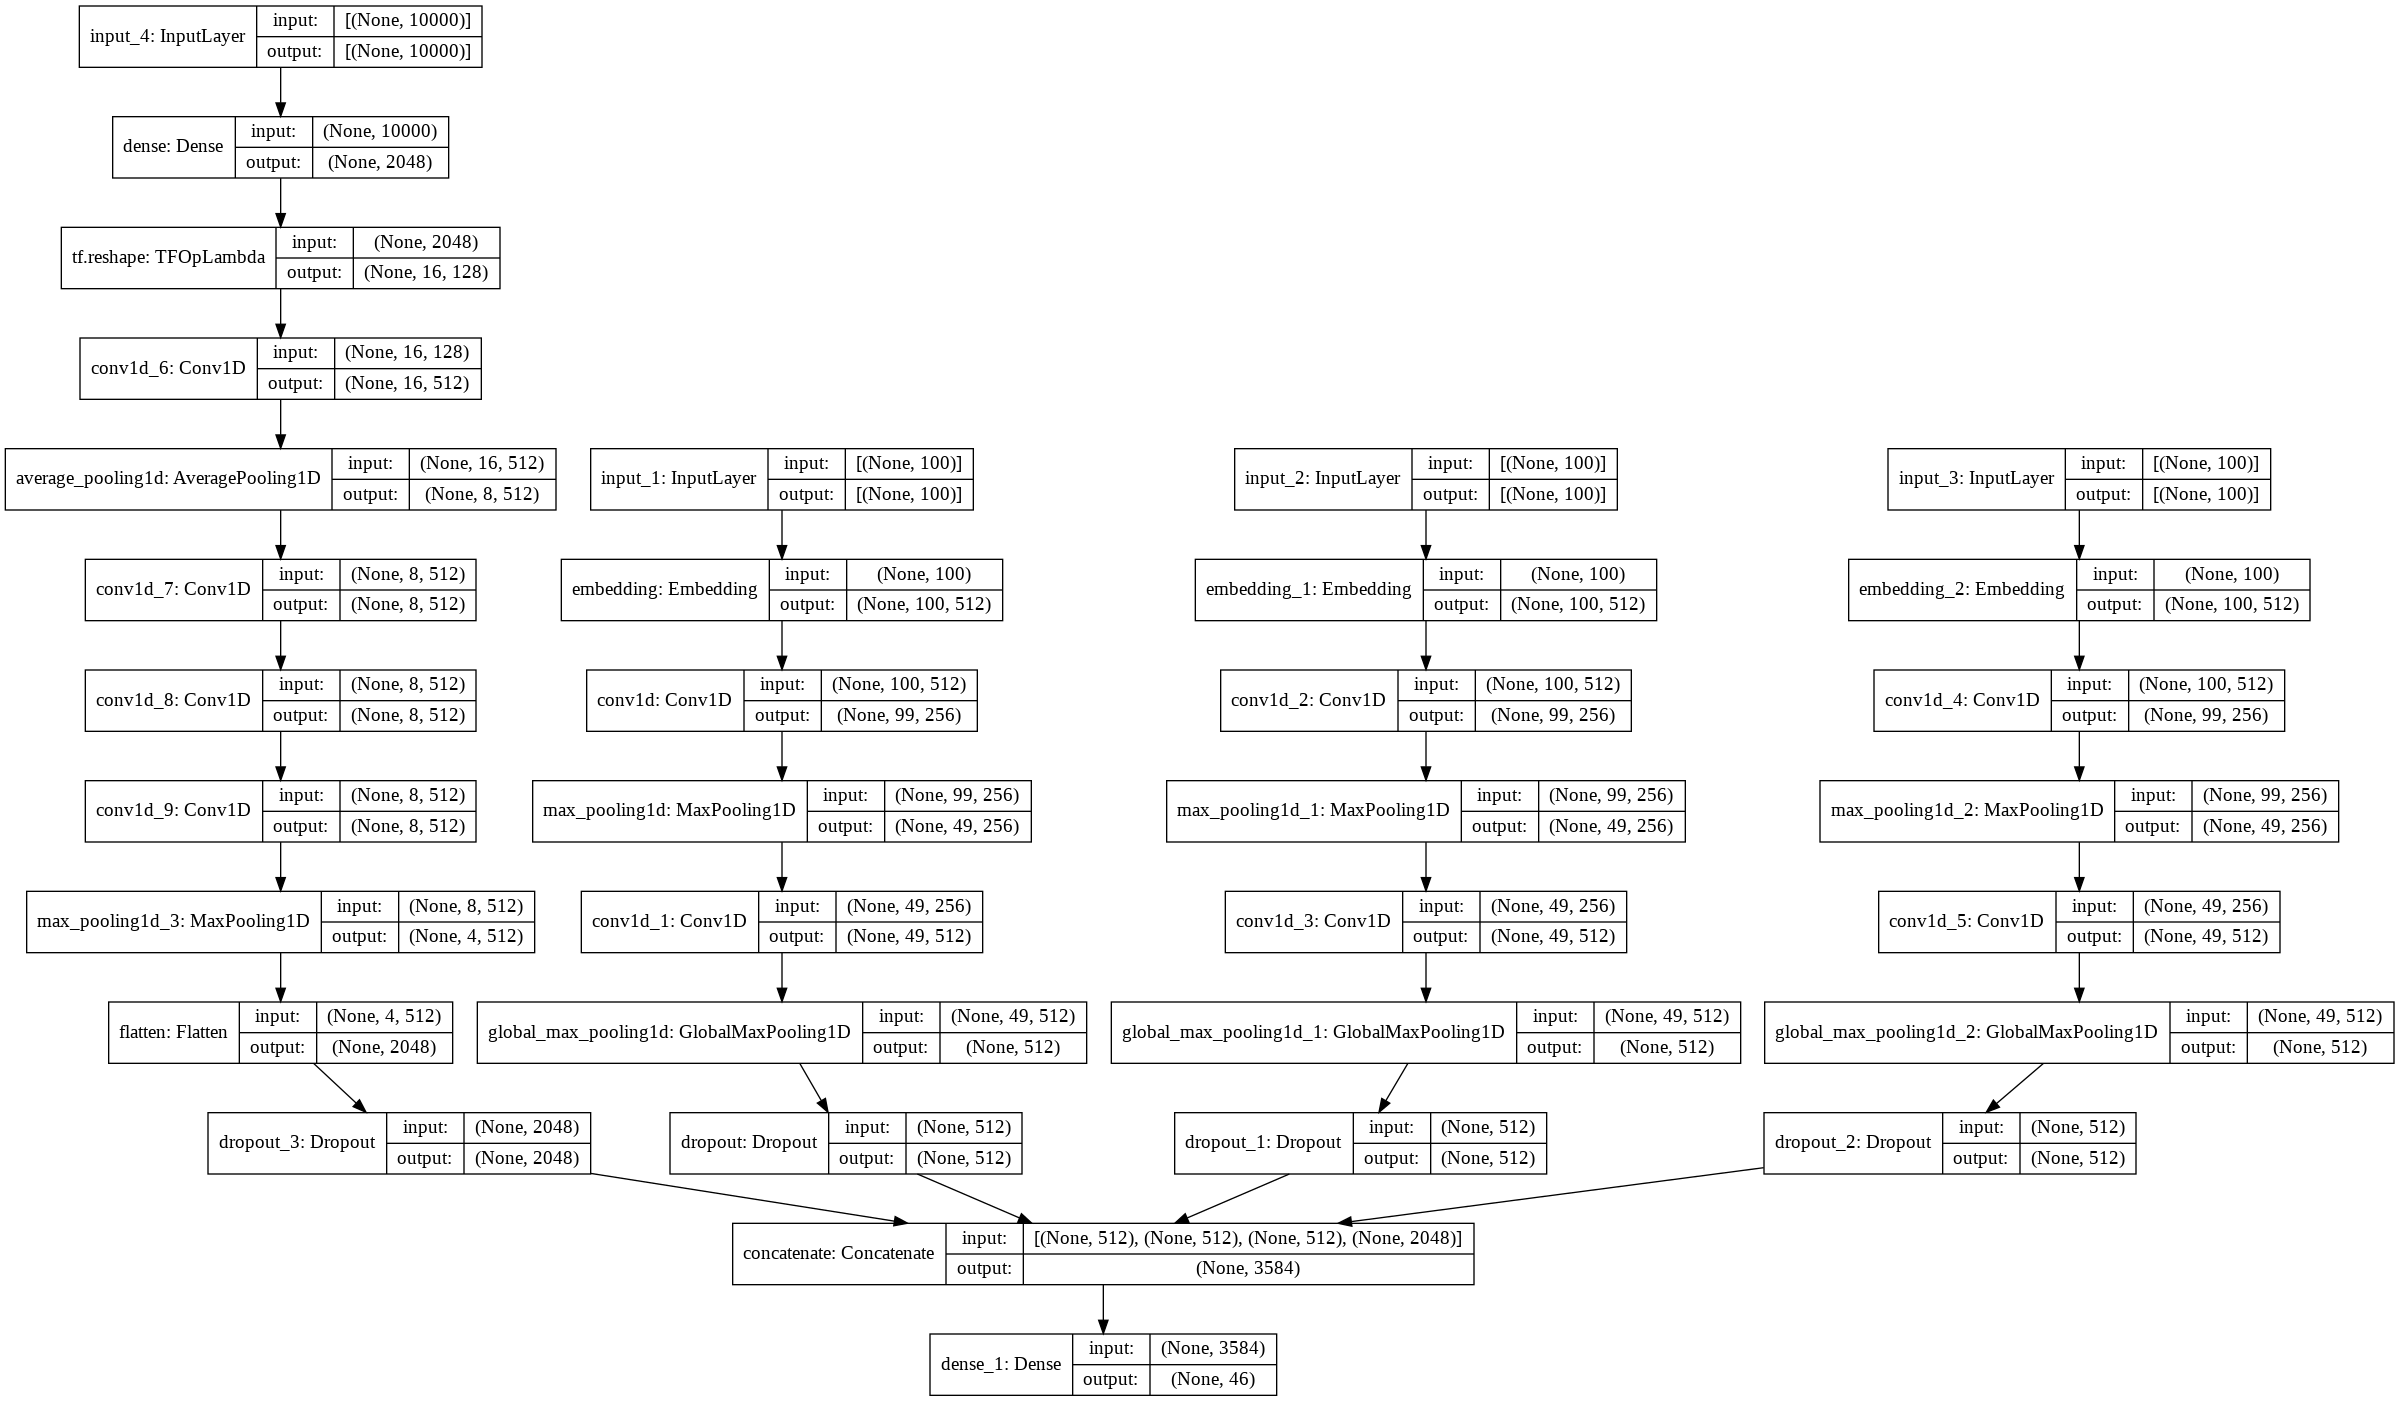

In [36]:
model = build_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

- 학습 시작
    - 리더보드 재현을 위해 모델 가중치를 불러올 경우 모델 학습만 진행 하지 않고 tfidf 피쳐생성 위한 fit 과 텍스트 토크나이징을 위한 fit 그리고  모델 하이퍼파라미터 저장만 실행 됩니다.
    - 모델을 학습할 경우 Colab Pro TPU & 배치사이즈 256 기준으로 처음 에폭을 제외하고 에폭당 30~35초 가량 걸립니다. 
    - CV 5 fold 로 학습을 진행합니다.(5개의 모델이 생성됩니다.)
    - 검증셋에 대하여 Transform 만 진행합니다. 이는 검증셋 에 대해서도 Data Leakage 요소를 제거하여 오버핏을 방지하고 일반화 성능을 높이기 위함 입니다. fit 을 총 5번 하기 때문에 추론 과정에서도 test 셋에 대하여 동일하게 5번 Transform 해서 TTA 효과도 기대합니다.

In [37]:
is_holdout = False # true 지정시 holdout 으로 만 학습합니다.. 나의 가설이 괜찮은지 holdout 으로 체크해봅니다.
model_idx = 0 # 모델 인덱스
n_splits = 5 # cv 개수
 
tt_list = [] # 토크나이저 클래스 객체 저장하기 위한 리스트
fg_list = []  # tdm or tfidf 등과 같은 테이블형 피쳐를 생성하는 클래스 객체를 저장하기 위한 리스트
hp_dict_list = [] # bulid_model 하이퍼파라미터를 저장하기 위한 리스트
 
scores = []
 
# 임베딩 레이어에 들어갈 컬럼 명 과 maxlen 값
cols_seq = [
            ("join1" ,train["join1"].str.split().str.len().max() ),
            ("요약문_연구목표_pre" ,train["요약문_연구목표_pre"].str.split().str.len().max() ),
            ("요약문_연구내용_pre" ,train["요약문_연구내용_pre"].str.split().str.len().max() ),
            ("요약문_기대효과_pre" , train["요약문_기대효과_pre"].str.split().str.len().max()),
            ("요약문_한글키워드_pre" ,train["요약문_한글키워드_pre"].str.split().str.len().max() ),
            ("요약문_영문키워드" ,train["요약문_영문키워드"].str.split().str.len().max() ), 
            ("join2" ,train["join2"].str.split().str.len().max() ), # 형태소 분석 안한 상태의 컬럼의 특징도 성능에 좋은 영향을 줌
            ("요약문_한글키워드" ,train["요약문_한글키워드"].str.split().str.len().max() ), # 형태소 분석 안한 상태의 컬럼의 특징도 성능에 좋은 영향을 줌
            ]
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for tri, vai in cv.split(train,y_train):
    reset_seeds(SEED)
    # f1 score 최적의 값을 내놓은 모델 가중치 복구
    es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5,mode="max",restore_best_weights=True)
 
    xt = train.iloc[tri].reset_index(drop=True) # 학습셋
    xv = train.iloc[vai].reset_index(drop=True) # 검증셋
    train_list = [] # 모델에 들어가는 학습 입력 데이터
    valid_list = [] # 모델에 들어가는 검증 입력 데이터
    
    # 텍스트 컬럼들 토큰화 및 패딩 진행
    seq_shape = [] # 모델 임베딩 레이어에 들어갈 컬럼의 단어 갯수와 길이 정보 리스트
    tt_dict = {} # 컬럼별로 TextTokenizer 객체를 담기 위한 딕셔너리
    for col,maxlen in cols_seq:
        tt = TextTokenizer(maxlen = maxlen ,padding = "post" ,filters='!"#$%&()*+,-.:;<=>?@[\\]^_`{|}~\t\n')
        tt.fit(xt[col]) # 학습 셋만 fit
        seq_shape.append(( len(tt.tokenizer.word_index) + 1,maxlen )) 
        tt_dict[col] = tt

        
        if not IS_LOAD_WEIGHTS:  # 재현을 위해 가중치 불러올경우 실행 안함
            train_list.append(tt.transform(xt[col])) # 학습셋 토크나이징 및 패딩작업
            valid_list.append(tt.transform(xv[col])) # 검증셋 토크나이징 및 패딩작업
        
    tt_list.append(tt_dict)   # 테스트셋 추론시 필요하므로 컬럼별로 TextTokenizer 객체를 담은 딕셔너리를 리스트에 저장
 
 
    # 일부 컬럼에 대한 Tfidf or TDM 피쳐 생성
    fg = FeatureGenerator(vec_num = 500 ,
                          cols_vec = ["요약문_한글키워드_pre"] , 
                          is_tdm = False, is_tfidf = True ,cols_not_sparse=cols_not_sparse)
    fg.fit(xt) # 학습 셋만 fit
    fg_list.append(fg) # 테스트셋 추론시 필요하므로 FeatureGenerator 객체 저장

    #모델 하이퍼파라미터
    hp_dict = {
        "seq_shape":seq_shape , 
        "embed_dim":128 , 
        "tab_shape" : fg.num_features, # 테이블형식의 피쳐 개수
        "label_smoothing" : 0.1,
    }
    hp_dict_list.append(hp_dict) # 테스트셋 추론시 필요하므로 하이퍼파라미터 저장

    if not IS_LOAD_WEIGHTS: # 재현을 위해 가중치 불러올경우 실행 안함
        xt = fg.transform(xt) # 학습셋 테이블형 피쳐 생성
        xv= fg.transform(xv) # 검증셋 테이블형 피쳐 생성 
    
        train_list.append(xt)
        valid_list.append(xv)
        print(xt.shape[1])
        
        # TPU 스코프 안에서 모델 컴파일 해야함
        with strategy.scope():
            model = build_model(**hp_dict)
    
        history = model.fit(train_list, get_onehot(y_train[tri]) , epochs=50, batch_size= 256,callbacks=[es], validation_data=(valid_list, get_onehot(y_train[vai]))
                            )
        
        # 모델 가중치 저장
        model.save_weights(f"{MODELS_PATH}{save_weights_name}{model_idx}.h5")
        scores.append(max(history.history["val_f1_score"]))
 
        del model
        del train_list
        del valid_list

    del xt
    del xv
    gc.collect()
    tf.keras.backend.clear_session()
 
 
    if is_holdout:
        break 
    
    model_idx +=1

RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42


In [38]:
scores

[]

- 테스트셋 추론 및 검증점수 확인

In [39]:
preds = [] # 각 폴드별 테스트셋에 대하여 예측 확률을 담기 위한 리스트
model_idx = 0 
scores_valid = []  # 검증 점수 리스트
scores_report_list = [] # 클래스 별 평가지표를 담기 위한 리스트
 
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for tri, vai in cv.split(train,y_train):
    
    # TPU 스코프 안에서 모델 컴파일 해야함
    with strategy.scope():
        model = build_model(**hp_dict_list[model_idx]) # 위에서 저장한 하이퍼 파라미터 세팅
        model.load_weights(f"{MODELS_PATH}{save_weights_name}{model_idx}.h5") # 저장된 모델 가중치 load

    xv = train.iloc[vai].reset_index(drop=True) # 검증셋

    valid_list = [] # 검증 입력데이터
    test_list = []  # 테스트 입력데이터
    
    # 각 컬럼별 토크나이징 및 패딩작업
    for col,maxlen in cols_seq:
        valid_list.append(tt_list[model_idx][col].transform(xv[col])) # 검증
        test_list.append(tt_list[model_idx][col].transform(test[col])) # 테스트
    
    # 테이블형 피쳐 생성
    xv = fg_list[model_idx].transform(xv) # 검증
    xte = fg_list[model_idx].transform(test) # 테스트
    valid_list.append(xv)
    test_list.append(xte)
    
    pred_valid = model.predict(valid_list) # 검증셋 예측
    pred_test = model.predict(test_list) # 테스트셋 예측
 
    preds.append(pred_test) # 테스트셋 예측확률 저장
    
    

    score = macro_f1(y_train[vai],pred_valid) # 검증셋 f1 score
    scores_valid.append(score)
    print( f"- {model_idx+1} fold score : {score}" )
    
    # 검증셋에 대하여 클래스별 평가지표 
    scores_report = classification_report(y_train[vai],np.argmax(pred_valid,axis=1),output_dict =True)
    scores_report_list.append(scores_report)
 
    del model
    del valid_list
    del test_list
    del xv
    del xte
    gc.collect()
    tf.keras.backend.clear_session()
 
    if is_holdout:
        break 
    model_idx +=1
    
 
print("-"*20)
 
print( f"- score mean : {np.mean(scores_valid)}" )

- 1 fold score : 0.7901381216583663
- 2 fold score : 0.7828301367891954
- 3 fold score : 0.7877464451028453
- 4 fold score : 0.7844174138267143
- 5 fold score : 0.7938667488758608
--------------------
- score mean : 0.7877997732505964


- 클래스별 f1 score 확인해보기

In [40]:
f1_scores_list = []
for scores in scores_report_list:
    f1_scores = []
    for label in range(46):
        f1_scores.append( scores[f"{label}"]["f1-score"] )

    
    f1_scores_list.append(f1_scores)
    print( np.mean(f1_scores) )

print("="*20)
class_scores = np.mean(f1_scores_list,axis=0)
for i,s in enumerate(class_scores):
    print(f"{i} class f1-score: {s}")

0.7901381216583663
0.7828301367891954
0.7877464451028453
0.7844174138267143
0.7938667488758608
0 class f1-score: 0.9701133519445166
1 class f1-score: 0.9112008858619373
2 class f1-score: 0.9419496081260788
3 class f1-score: 0.7548515117882487
4 class f1-score: 0.9096442687747036
5 class f1-score: 0.8941812504384089
6 class f1-score: 0.8349422129594544
7 class f1-score: 0.8465422722484549
8 class f1-score: 0.9396495162826298
9 class f1-score: 0.8348894348894349
10 class f1-score: 0.7652707329119736
11 class f1-score: 0.6645422313069372
12 class f1-score: 0.7062238827251337
13 class f1-score: 0.8035214837500464
14 class f1-score: 0.8757061003351627
15 class f1-score: 0.8315277328276617
16 class f1-score: 0.7459227325427873
17 class f1-score: 0.4978743092788177
18 class f1-score: 0.7812795138170238
19 class f1-score: 0.8083047517439119
20 class f1-score: 0.4842620091851912
21 class f1-score: 0.8762252838763276
22 class f1-score: 0.7586965474448888
23 class f1-score: 0.8233639042805668
24 

- 다른 모델과 앙상블 하기위해 SUBMIT_INPUT_PATH 경로에 npy 파일로 저장 

In [41]:
np.save(f'{SUBMIT_INPUT_PATH}{save_weights_name}', preds)

## 개인모델 점수 확인할 경우 is_to_csv 변수 값을 True 변경 후  실행

In [42]:
is_to_csv = False

In [43]:
if is_to_csv:
    pred = np.mean(preds,axis=0)
    print(len(preds))
    pred = tf.argmax(pred,axis=1)
    pred

In [44]:
if is_to_csv:
    sample_submission["label"] = pred
    sample_submission

In [45]:
if is_to_csv:
    sample_submission.to_csv(f'{SUBMIT_OUTPUT_PATH}{save_weights_name}.csv', index=False)